# <font color=red> Truss Issues

## Welcome to truss bridge generation

<img src="download.png">

In [29]:
import numpy as np
from openopt import NLP
import matplotlib.pyplot as plt
%matplotlib inline

In [30]:
def structtruss(p1, p2, xnum, ynum):
    pinjoints = []
    segments = []
    # making a dotted structure of entire space
    xspan = np.linspace(p1[0], p2[0], xnum + 1)
    yspan = np.linspace(p1[1], p2[1], ynum + 1)
    for y in yspan:
        for x in xspan:
            pinjoints.append([x, y])  # making a grid of dots
    for j in range(ynum):
        for i in range(xnum):
            inter = j * (xnum + 1)
            p1 = i + inter
            p2 = p1 + 1
            p3 = p1 + xnum + 1
            p4 = p3 + 1
            segments.extend([[p1, p2], [p1, p3], [p1, p4], [p2, p3]])
        segments.append([p2, p4])
    idx = ynum * (xnum + 1) + 1
    for j in range(xnum):
        # create segments between pinjoints.
        segments.append([idx + j - 1, idx + j])
    return np.array(pinjoints), np.array(segments)

In [36]:
def genalgtruss(dots, cons, ym, F, freepj, V0, plotdisp=False):
    n = cons.shape[0] #number of bars
    m = dots.shape[0] #number of nodes
    vecs = dots[cons[:, 1], :] - dots[cons[:, 0], :]      #A vector between each dot in the truss
    l = np.sqrt((vecs ** 2).sum(axis=1))             # the displacement between each point
    e = vecs.T / l       #unitary directive (unit vector)
    B = (e[np.newaxis] * e[:, np.newaxis]).T    #elongation per unit l
    
    def objfunc(x):
        D = ym * x / l      #Stiffness = E(the cross section area)/length
        kx = e * D          #force generated (element wise stiffness)
        KZ = np.zeros((2 * m, 2 * m)) 
        for i in range(n):
            aux = 2 * cons[i, :]
            idx = np.r_[aux[0]:aux[0] + 2, aux[1]:aux[1] + 2]
            K0 = np.concatenate((np.concatenate(
                (B[i], -B[i]), axis=1), np.concatenate((-B[i], B[i]), axis=1)), axis=0)        #Stiffness matrix
            KZ[np.ix_(idx, idx)] = KZ[np.ix_(idx, idx)] + D[i] * K0 

        box = freepj.flatten().nonzero()[0]      #freepj = array of free pin joints    (1Xn)
        mat = KZ[np.ix_(box, box)]               # (nXn)
        rhs = F.flatten()[box]                   #a vector of forces applied   (1Xn^2)
        answer = np.linalg.solve(mat, rhs)       #ax=b
        u = freepj.astype("float").flatten()
        u[box] = answer
        U = u.reshape(m, 2)        #displacement vector
        axis = ((U[cons[:, 1], :] - U[cons[:, 0], :]) * kx.T).sum(axis=1)      
        stress = axis / x
        loss = (U * F).sum()
        dloss = -stress ** 2 / ym * l
        return loss, dloss, U, stress

    def vol(x):
        return (x * l).sum(), l

    def trussform(x, factor=3, wdt=5e2):
        U, stress = objfunc(x)[2:]
        newdots = dots + factor * U
        if plotdisp:
            fig = plt.figure(figsize=(12, 6))
            ax = fig.add_subplot(121)
            bx = fig.add_subplot(122)
        else:
            fig = plt.figure()
            ax = fig.add_subplot(111)

        for i in range(n):
            segments1 = np.concatenate((dots[cons[i, 0], :][np.newaxis],
                                        dots[cons[i, 1], :][np.newaxis]), axis=0)
            segments2 = np.concatenate((newdots[cons[i, 0], :][np.newaxis],
                                        newdots[cons[i, 1], :][np.newaxis]), axis=0)
            if stress[i] > 0:
                clr = "r"
            else:
                clr = "g"
            ax.plot(segments1[:, 0], segments1[:, 1],
                    color=clr, linewidth=wdt * x[i])
            ax.axis("equal")
            ax.set_title("Stress per bar")
            if plotdisp:
                bx.plot(segments1[:, 0], segments1[:, 1], "r:")
                bx.plot(segments2[:, 0], segments2[:, 1],
                        color="k", linewidth=wdt * x[i])
                bx.axis("equal")
                bx.set_title("Displacement on load")

            ax.plot([0, 0.6], [0, 0], color="black", linewidth=wdt * 0.001)
            bx.plot([0, 0.6], [0, 0], color="black", linewidth=wdt * 0.001)
            plt.setp(ax, xticks=[], yticks=[])
        plt.setp(bx, xticks=[], yticks=[])
        plt.show()

    xminimum = 1e-6 * np.ones(n)
    xmaximum = 1e-2 * np.ones(n)

    def rfreeobj(x): return objfunc(x)[0]

    def efreeobj1(x): return objfunc(x)[1]
    totalvol = vol(xmaximum)[0]

    def constr(x): return 1. / totalvol * vol(x)[0] - V0

    def dconstr(x): return 1. / totalvol * vol(x)[1]
    x0 = 1e-4 * np.ones(n)
    # Optimize rfreeobj, starting at x0.
    problem = NLP(rfreeobj, x0, df=efreeobj1, c=constr, dc=dconstr, lb=xminimum,
                  ub=xmaximum, name="Truss Optimization", iprint=100, maxIter=1500)
    result = problem.solve("ralg")
    trussform(result.xf)

In [37]:
def visualtruss(width=11, height=3, E=1e+7):
    sf = 0.4
    dots, cons = structtruss(
        (0, 0), (0.6, (height-1) / 10), width - 1, height-1)
    YM = E  # Young's Modulus
    ym = YM*np.ones(cons.shape[0])
    onload = np.zeros_like(dots) #the external forces acting on each node
    for i in range(1, int((width + 1)/2)):
        onload[i, 1] = - 30 * i
        onload[width - i - 1, 1] = - 30 * i 
    onload = onload * sf
    freepj = np.ones_like(dots).astype("int") #freedom of the i-th node: 0 if it is fixed, and 1 otherwise.
    freepj[0, :] = 0
    freepj[width - 1, :] = 0
    genalgtruss(dots, cons, ym, onload, freepj, 0.1, True) #0.1 = a parameter corresponding to the normalization of Vmax

## Enter width 

In [38]:
q1 = int(input())


11


## Enter height

In [39]:
q2 = int(input())

3


## Enter value of Young's Modulus for your material in mega psi

12

------------------------- OpenOpt 0.5629 -------------------------
problem: Truss Optimization   type: NLP    goal: minimum
solver: ralg
variables: 92
constaints:  non-linear {1 ineq  0 eq}
  iter  objFunVal  log10(maxResidual)  
    0  1.132e+01            -100.00 
  100  3.310e-01              -0.55 
  200  3.028e-01              -1.04 
  300  4.400e-01              -0.47 
  400  2.300e-01              -0.37 
  500  3.585e-01              -0.46 
  600  2.550e+00              -0.83 
  700  6.895e-01              -0.82 
  800  2.851e+00              -1.87 
  900  6.068e-01              -5.51 
 1000  4.902e-01              -4.25 
 1100  4.651e-01            -100.00 
 1191  4.623e-01              -6.32 
istop: 4 (|| F[k] - F[k-1] || < ftol)
Solver:   Time Elapsed = 31.1  	CPU Time Elapsed = 51
objFuncValue: 0.46232459 (feasible, MaxResidual = 4.83219e-07)


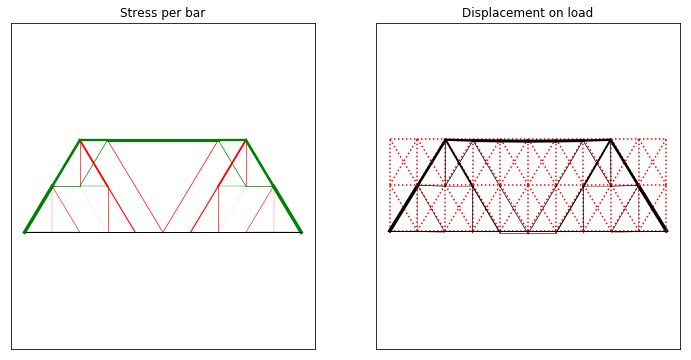

In [40]:
q3 = float(input())
q3 = q3*1e+6
visualtruss(q1,q2,q3)